# 1 state Climate model
Assume emissions E, cumulative emissions S, temperature proportional to cumulative emissions $T=\zeta S$, and a production function with quadratic damages and linear marginal abatement costs, both proportional to production. As a result, consumption is $C=c_0 exp(gt+\phi E -\varphi/2 E^2-\gamma \zeta^2 /2 S^2$. define consumption per unit of effective labor $c=C/exp(gt)$ 
Maximize expected utility
$max_E \sum_{t} e^{-(\delta +(\eta -1 )g)t} \{ \frac{c_t ^{1-\eta}}{1-\eta}-\lambda_t (S_t+E_t+e_t -S_{t+1}) \}$



First order conditions for maximum

$c^{1-\eta}(\phi - \varphi E_t)=\lambda_t$

$e^{-(\delta +(\eta -1 )g)} c_{t+1}^{1-\eta}(\gamma \zeta^2 S_{t+1} +\lambda_{t+1})-c_{t}^{1-\eta}\lambda_t=0$

Assume the effect of both abatement costs and damages on the consumption growth rate is small and constant $\frac{c_{t+1}}{c_t}=e^\epsilon$. Define $r=\delta+(\eta -1)(g-\epsilon)$.  Substitute out $\lambda$.

$e^{-r} c_{t+1}(\gamma \zeta^2 S_{t+1}+\phi-\varphi E_{t+1})-c_{t+1}(\phi-\varphi E_t)=0$

Define the yearly (non-continuous) growth rate ${e^{-r}=\frac{1}{1+\tilde{r}}}$

 $\frac{1}{1+\tilde{r}} (\gamma \zeta^2 S_{t+1}+\phi-\varphi E_{t+1})-(\phi-\varphi E_t)=0$

 Transversality condition is $lim_{t->\infty}\lambda_t e^{-rt}=0$.  I coded this as $\lambda_{t+1}/(1+\tilde{r})<\lambda_{t}$ (MAC cannot increase faster than the discount rate). However, applying this transversality condition still gives rising emissions, starting at 2.6 times business as usual if the neural net allows for it. Also, it does not necessarily apply to the short run (though it does in this example).
 
 Combining the transversality condition with the costate equation we get $lim_{t->\infty}\frac{\lambda_{t+1}}{c^{1-\eta}\gamma\zeta²S_{t+1}}>0$ which implies a non-negative MAC and therefore emissions below BAU. Indeed appendix B in my JEEM paper shows that non-negative MAC sets the second integration constant and implies a steady state. In practice, adding a constraint that emissions cannot exceed BAU emissions (or using tanh in last layer) gives the correct solution. However in a 2-state model, that does not give a meaningful solution (probably because I do not use an explicit transversality condition for capital).

 To impose the existence of a steady state where emissions are zero, I could impose zero emissions around the steady state, using a bell-shaped penalty (to have a good gradient towards the optimal solution). Alternatively, I could impose decreasing emissions below the steady state and increasing emissions beyond the steady state. Are these interesting?

Remark :This model uses parameters of my Banque de France course and code is based on Simon's ABC model.


In [1]:
# Import necessary libraries
import numpy as np
import math
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams["font.size"] = 15

%matplotlib inline

#only work with cpu
tf.config.set_visible_devices([], 'GPU')


print("Version of tensorflow is {}".format(tf.__version__))


Version of tensorflow is 2.15.0


## Evaluation operator
Calculate probability weights and discrete values (notes) for stochastic shocks.

In [2]:
n_int = 5 # integration nodes
x_int_norm, w_int = np.polynomial.hermite.hermgauss(n_int) # obtain standard GH nodes and weights
w_int = w_int / np.sqrt(np.pi) # divide the weights by sqrt(pi)
x_int_norm = x_int_norm * np.sqrt(2) # multiply weights with 2**0.5

#convert to tensorflow
x_int_norm = tf.constant(x_int_norm, dtype = tf.float32)
w_int = tf.constant(w_int, dtype = tf.float32)


# we should make sure the weights some to 1
print("sum(w_int) = ", np.sum(w_int))
print("weights: ", w_int)
print("Nodes: ", x_int_norm)

sum(w_int) =  1.0000001
weights:  tf.Tensor([0.01125741 0.22207592 0.53333336 0.22207592 0.01125741], shape=(5,), dtype=float32)
Nodes:  tf.Tensor([-2.85697   -1.3556262  0.         1.3556262  2.85697  ], shape=(5,), dtype=float32)


## Model parameters

In [3]:
#PARAMETERS
# preferences
rho=0.006   #utility discount rate reduced by population growth
eta=1.35;     #elasticity of marginal utility wrt consumption

#economic model
g=0.02;       #exogenous growth rate
r=rho+(eta-1)*g #growth adjusted discount rate
sigmaS=0.001;  #standard deviation of Brownian motion on S
A=5.115;      #total factor productivity from DICE
L=7.403;      #popuation from DICE
alpha=0.3;    #elasticity of capital in Cobb-Douglas from DICE
K0=223;       #initial capital from DICE
delta_c=0.1;  #depreciation rate per year

#Abatement costs (emissions in TtCO2)
phi=0.00126*1000;  #MAC intercept
varphi=0.00003*1000**2;#MAC slope 
E0=phi/varphi #BAU emissions

#Climate and damages
zeta=0.0006*1000;  #TCRE per TeratCO2
gammaT=0.01;  #damage as proportion of GDP is exp(0.5*gammaT*T²)
gamma=zeta**2*gammaT; # gamma includes the TCRE
S0=2000/1000;      #initial cumulative emissions

# helper
eps = 0.00001

## Neural network architecture

In this section, I define the architecture of the deep neural net.
States are cumulative emissions and capital. They are the input into the NN. The decision variables are investment and emissions, but to be able to use sigmoid function, which stays between 0 and 1, I will use investment over production and emissions over initial emissions as decision variables.

Therefore, the neural network input is a 2-dimensional state $\mathbf{X}_t = [Sx, Kx]$ and the output is the 2-dimensional vector $\mathbf{Y}_t = [Esharey, Isharey]$.

I use 2 hidden layers with 128 nodes each (ad-hoc) with each hidden layer having a relu activation function.  

For the output layer I chose a sigmoid function for the investment share and softplus for emissionshare to ensure nonnegativity.


In [4]:
# Layer setting
num_input = 1
num_hidden1 = 128
num_hidden2 = 128
num_output = 1
layers_dim = [num_input, num_hidden1, num_hidden2, num_output]
print("Dimensions of each layer are {}".format(layers_dim))

Dimensions of each layer are [1, 128, 128, 1]


In [5]:
# Define the nn
#nn = keras.Sequential([
#    keras.layers.Dense(num_hidden1, activation='relu', input_shape=(num_input,)),
#    keras.layers.Dense(num_hidden2, activation='relu'),
#    keras.layers.Dense(num_output, activation='softplus')
#])

Inlayer = keras.Input(shape=(num_input,))
hidden1 = keras.layers.Dense(num_hidden1, activation='relu')(Inlayer)
hidden2 = keras.layers.Dense(num_hidden2, activation='relu')(hidden1)
#leaky_relu=tf.keras.layers.LeakyReLU(alpha=0.2) #Leaky relu makes a kink at the steady state, elu does not 
outlayer= keras.layers.Dense(num_output,  activation='tanh')(hidden2) #elu is good alternative provided there is a penalty for emissions exceeding BAU. It has left assymptote at y=-1 and gives y=x for x>0. Allows for negative emissions.

#neuronE = keras.layers.Dense(1, activation = "sigmoid")(hidden2)  #alternative is sigmoid to avoid negative emissions, but in stochastic environment negative emissions are required
#outlayer = keras.layers.concatenate([neuronE])

nn = keras.Model(inputs=Inlayer, outputs=outlayer)
nn.build(input_shape=(None, num_input))


### Evaluate expectation

In [6]:
@tf.function
def get_singleinside(X_next, nn):

    # read out the state
    Sx_next = X_next[:, 0 : 1]


    # use the neural network to predict E_next 
    Y_next = nn(X_next)

    # read out Y
    Ey_next = Y_next*E0

    # compute term inside the expectation
    MD_MAC  =    gamma * Sx_next + phi - varphi * Ey_next 
    
    #compute MAC for transversality condition that MAC should not increase faster than discount rate
    MAC = phi - varphi * Ey_next 

    ret=tf.concat([MD_MAC,MAC], axis=1)
    return ret

In [7]:
@tf.function
def compute_cost(X, nn): #FV: unlike in Matlab, the function can use variables that are stored in the elsewhere in the code such as w_int and x_int_norm


    n_data = X.shape[0] # number of states is on the axis 0
    dim_state = X.shape[1] # dimensionality of the state is on axis 1

    # read out the state
    Sx = X[:, 0 : 1] # X[:,0] gives a 1D tensor, X[:, 0 : 1] gives a 2D tensor of size n*1
  

    # use the neural network to predict the controls
    Y = nn(X)
    Esharey=Y[:, 0 : 1] #alternative if one uses sigmoid activation: Esharey=Y[:, 0 : 1]-0.1 if initial emissions are less than 90% of BAU and negative emissions do not exceed -10% of BAU. 
    # compute Emissions
    Ey =  Esharey * E0

    # now we have to compute the expectation
    expectation = tf.zeros((n_data, dim_state+1)) #FV this will make a nx2 matrix, we have 1 state, but it comes with a transversality

    # we loop over the integration nodes
    for i in range(n_int):
        # integration weight
        weight_i = w_int[i]

        # innovation to the AR(1)
        innovation_Ei = sigmaS * x_int_norm[i] #innovation is  0.001*2.8  (2.8GtCO2) in worst case node

        # construct exogenous shock at t+1
        Sx_next= Sx + Ey + innovation_Ei

        # compute term inside the expeectation
        inside_i = get_singleinside(Sx_next, nn)

        # add term to the expectaion with the appropriate weight 
        expectation = expectation + weight_i * inside_i

    # now we have all terms to construct the relative Euler error

    # Define the relative Euler error
    errSCC     = (1+r)**(-1)* expectation[:,0:1] - (phi-varphi*Ey)
    #Transversality condition: penalty if carbon price increases faster than the discount rate: this does not impede emissions exceeding BAU emissions in dace ELU is used in last layer.
    errTransver= (1+r)**(-1)* expectation[:,1:2] - (phi-varphi*Ey)
    #convert bool to float and scale the error, because dummies have zero gradient
    errTransver= tf.cast(errTransver>0, dtype = tf.float32)*errTransver*100
        #Alternative: : penalty if emissions exceed bau emissions
        #errTransver=Ey>E0  #unnecessary for ELU, necessary with relu, because the mismatch of zero emissions beyond the steady state can be avoided by chosing the wrong solution of emissions beyond BAU with negative MAC
        #convert bool to float and scale the error, because dummies have zero gradient
        #errTransver= tf.cast(errTransver, dtype = tf.float32)*(Ey-E0)  
        #Alternative2:  penalty if MAC decreases  (problem: before the steady state MAC should increase, beyond steady state MAC should decrease)#errTransver= expectation[:,1:2] < (phi-varphi*Ey) 

        
    cost = tf.math.reduce_sum(errSCC ** 2 + errTransver ** 2) / n_data

    # we return some more things for plotting
    LHS =  phi-varphi*Ey                   # LHS of Euler equation
    RHS =  (1+r)**(-1)*expectation[:,0:1]  # RHS of Euler equation

    return cost, errSCC, errTransver, Esharey, Ey, LHS, RHS


### Optimization of Neural Network

In [8]:
def grad(X, nn):
    with tf.GradientTape() as tape:
        loss_value = compute_cost(X, nn)[0]
    return loss_value, tape.gradient(loss_value, nn.trainable_variables)

In [9]:
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [10]:
def get_training_data(S_lb, S_ub, n_data):

    S = tf.random.uniform(
        shape = [n_data, 1],
        minval=S_lb,
        maxval=S_ub,
        dtype=tf.dtypes.float32)
    return S

In [11]:
# Run the optimization algorithm
# Keep results for plotting
train_loss = []

num_episodes =2001  #20001
n_data_per_epi =256
S_lb = S0
S_ub = 5000/1000


for ep in range(num_episodes):
    # generate training data
    X = get_training_data(S_lb, S_ub, n_data_per_epi)
    
    # compute loss and gradients
    loss, grads = grad(X, nn)

    # apply gradients
    optimizer.apply_gradients(zip(grads, nn.trainable_variables))

    # record loss
    train_loss.append(loss.numpy())

    # print progress
    if ep % int(0.1 * num_episodes) == 0:
        print("#=================================================================")
        print("episode = {}, loss [log10] = {}".format(ep, np.log10(loss.numpy())))

#=================================================================
episode = 0, loss [log10] = -3.7919671535491943
#=================================================================
episode = 200, loss [log10] = -7.779987812042236
#=================================================================
episode = 400, loss [log10] = -7.830978870391846
#=================================================================
episode = 600, loss [log10] = -7.891017436981201
#=================================================================
episode = 800, loss [log10] = -7.823360919952393
#=================================================================
episode = 1000, loss [log10] = -7.78081750869751
#=================================================================
episode = 1200, loss [log10] = -7.826286792755127
#=================================================================
episode = 1400, loss [log10] = -7.895238876342773
#=================================================================
epis

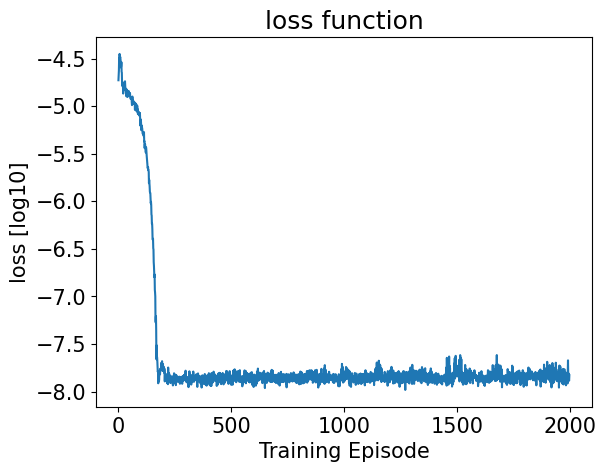

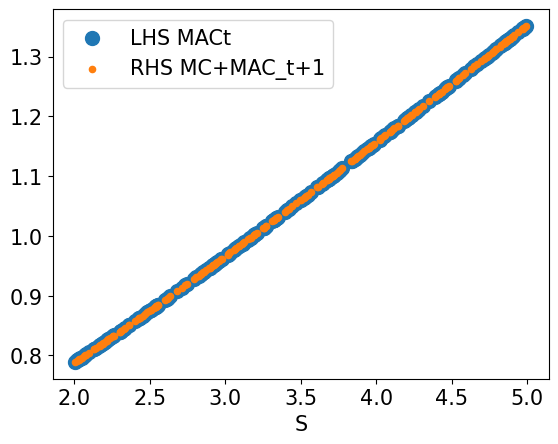

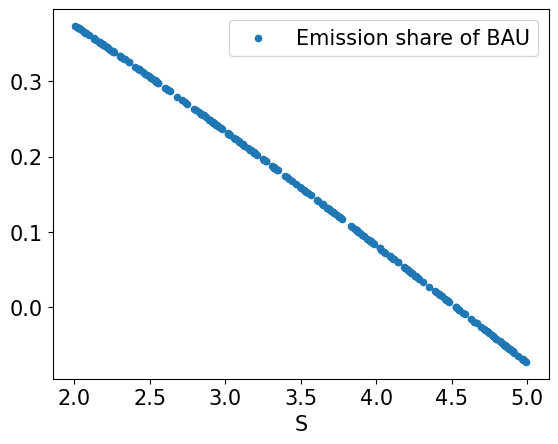

In [12]:
cost, errSCC, errTransver, Esharey, Ey, LHS, RHS = compute_cost(X, nn)

plt.title("loss function")
plt.plot(np.log10(np.array(train_loss[5:])))
plt.xlabel("Training Episode")
plt.ylabel("loss [log10]")
plt.show()
plt.close()

plt.xlabel("S")
plt.scatter(X[:, 0], LHS[:, 0], s = 100, label="LHS MACt")
plt.scatter(X[:, 0], RHS[:, 0], s = 20, label="RHS MC+MAC_t+1")
plt.legend()
plt.show()
plt.close()

plt.xlabel("S")
plt.scatter(X[:, 0], Esharey, s = 20, label="Emission share of BAU")
plt.legend()
plt.show()
plt.close()



### Try again with simulation

In [13]:
@tf.function
def simulate_single_step(X, eps_tplus1, nn):
    # function simulates the economy one step forward based on the neural network policy and the innovation

    n_data = X.shape[0]    # number of states is on the axis 0 (FV: number of stochastic realizations )
    dim_state = X.shape[1] # dimensionality of the state is on axis 1

    # read out the state
    Sx = X[:, 0 : 1] 


    # use the neural network to predict the optimal emissions and investment
    Y = nn(X)

    # read out Y
    Esharey = Y[:, 0 : 1]

    # compute Emissions, production & Investment today
    Ey = Esharey * E0

    # innovation to the AR(1)
    innovation_Ei = eps_tplus1[:,0, tf.newaxis]

    # construct exogenous states at t+1
    Sx_next = Sx + Ey + innovation_Ei

    # construct the next step
    X_next = tf.concat([Sx_next],axis = 1)

    return X_next

def sim_periods(X_start, nn, num_periods):
    n_tracks = X_start.shape[0] # number of states is on the axis 0 (FV number of stochastic realizations)
    dim_state = X_start.shape[1] # dimensionality of the state is on axis 1

    # create an empty array to store the states
    X_simulation = np.empty((num_periods, n_tracks, dim_state)) # 0 axis: time period, 1 axis: the different trajectories, 2 axis: the different state variables

    # draw random innovation
    eps = tf.random.normal((num_periods, n_tracks,1), dtype = tf.float32) * sigmaS # number of shocks hard coded 
    #scale the shock
    #eps = eps * sigmaS
    
    # set starting state
    X_simulation[0, :, :] = X_start

    X_old = X_start

    # simulate the periods
    for t in range(1, num_periods):
        eps_use = eps[t, :, :] # newaxis makes sure the shape is n_tracks x n_shocks (n_tracks x 1)

        X_new = simulate_single_step(X_old, eps_use, nn)

        X_simulation[t, :, :] = X_new

        X_old = X_new

    return X_simulation


def get_training_data_simulation(X_start, nn, n_periods):
    n_tracks = X_start.shape[0]
    n_dim = X_start.shape[1]

    # we simulate the model
    X_simulation = sim_periods(X_start, nn, n_periods)

    # we read out the last state (so that we can use it as starting point for the next simulation)
    X_end = np.float32(X_simulation[-1, :, :])

    # we reshape the data into (n_tracks * n_periods) x 2 array
    X_training = np.float32(np.reshape(X_simulation, (n_tracks * n_periods, n_dim)))

    return X_training, X_end

In [14]:
# let's get a new neural network
Inlayer = keras.Input(shape=(num_input,))
hidden1 = keras.layers.Dense(num_hidden1, activation='relu')(Inlayer)
hidden2 = keras.layers.Dense(num_hidden2, activation='relu')(hidden1)
neuronE = keras.layers.Dense(1, activation = "tanh")(hidden2) #sigmoid is used for investment in ABC model
outlayer = keras.layers.concatenate([neuronE])

nn = keras.Model(inputs=Inlayer, outputs=outlayer)
nn.build(input_shape=(None, num_input))


In [15]:

n_tracks = 256
n_periods = 1  #this seems very little
print("n_tracks = ", n_tracks)
print("n_periods = ", n_periods)

# start from a random state
X_start = get_training_data(S_lb, S_ub, n_tracks)
print("X_start.shape = ", X_start.shape)
print("With every simulation we get", n_tracks * n_periods, "new states")
#print("X_start",X_start[0,:])

X_training, X_end = get_training_data_simulation(X_start, nn, n_periods)
print("X_training.shape = ", X_training.shape)
print("X_end.shape = ", X_end.shape)
#print("X_end",X_end[0,:])
learning_rate = 10e-4
print("learning_rate = ", learning_rate)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

print(compute_cost(X_start, nn)[0])

n_tracks =  256
n_periods =  1
X_start.shape =  (256, 1)
With every simulation we get 256 new states
X_training.shape =  (256, 1)
X_end.shape =  (256, 1)
learning_rate =  0.001
tf.Tensor(2.4280762e-05, shape=(), dtype=float32)


##Run the model

In [16]:
# Keep results for plotting
train_loss = []

num_episodes = 1001

# initialize X_start
X_start = X_end
print("n_tracks = ", X_start.shape[0])
print("n_periods = ", n_periods)

for ep in range(num_episodes):
    # generate training data, now by sampling
    X, X_end = get_training_data_simulation(X_start, nn, n_periods)

    # update X_start
    X_start = X_end

    # compute loss and gradients
    loss, grads = grad(X, nn)

    # apply gradients
    optimizer.apply_gradients(zip(grads, nn.trainable_variables))

    # record loss
    train_loss.append(loss.numpy())

    # print progress
    if ep % int(0.05 * num_episodes) == 0:
        print("#=================================================================")
        print("episode = {}, loss [log10] = {}".format(ep, np.log10(loss.numpy())))

n_tracks =  256
n_periods =  1
#=================================================================
episode = 0, loss [log10] = -4.614737510681152
#=================================================================
episode = 50, loss [log10] = -5.1753339767456055
#=================================================================
episode = 100, loss [log10] = -7.364028453826904
#=================================================================
episode = 150, loss [log10] = -7.839508056640625
#=================================================================
episode = 200, loss [log10] = -7.850117206573486
#=================================================================
episode = 250, loss [log10] = -7.850255966186523
#=================================================================
episode = 300, loss [log10] = -7.850167751312256
#=================================================================
episode = 350, loss [log10] = -7.850222587585449
#==========================================

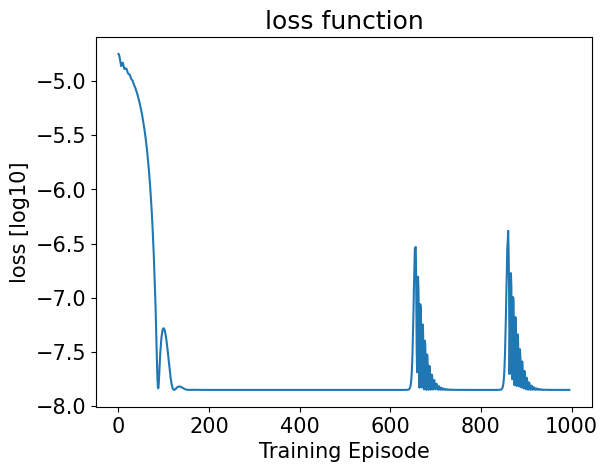

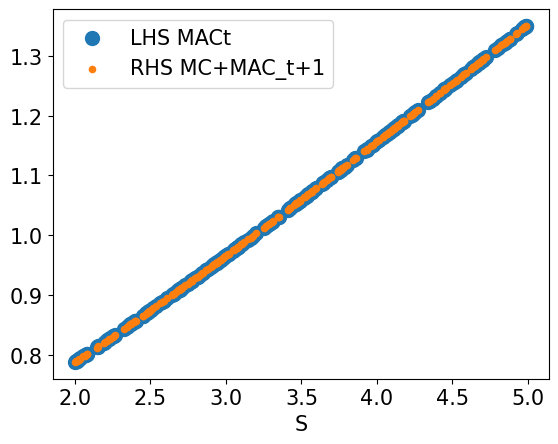

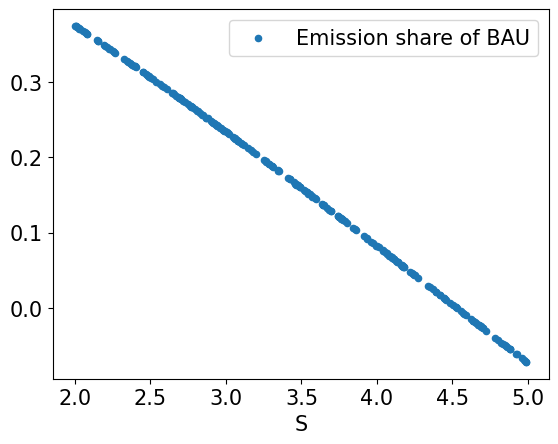

In [17]:

cost, errSCC, errTransver, Esharey, Ey, LHS, RHS = compute_cost(X, nn)

plt.title("loss function")
plt.plot(np.log10(np.array(train_loss[5:])))
plt.xlabel("Training Episode")
plt.ylabel("loss [log10]")
plt.show()
plt.close()

plt.xlabel("S")
plt.scatter(X[:, 0], LHS[:, 0], s = 100, label="LHS MACt")
plt.scatter(X[:, 0], RHS[:, 0], s = 20, label="RHS MC+MAC_t+1")
plt.legend()
plt.show()
plt.close()

plt.xlabel("S")
plt.scatter(X[:, 0], Esharey, s = 20, label="Emission share of BAU")
plt.legend()
plt.show()
plt.close()




## Policy function

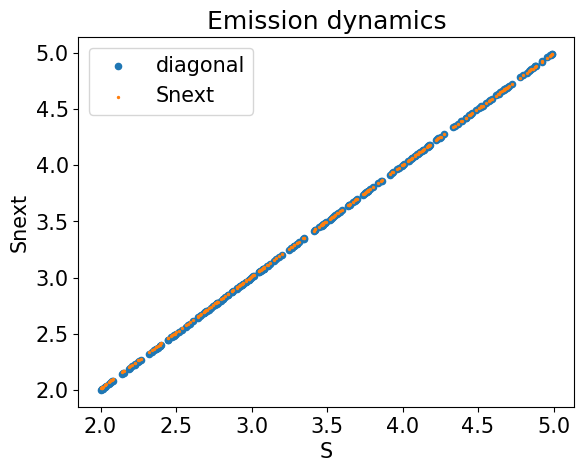

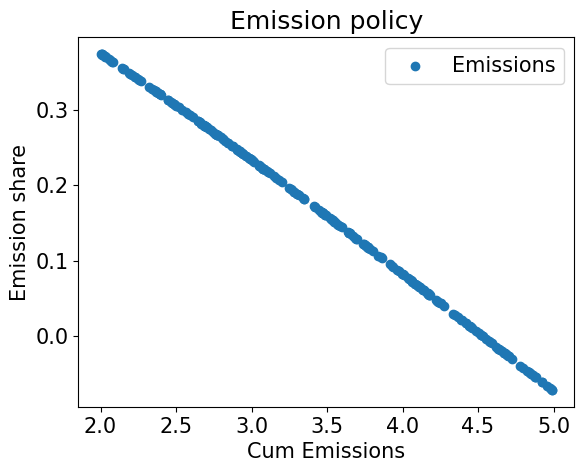

In [18]:
policy_guess = nn(X)

#Iy + (1-delta) * Kx
Ey = policy_guess[:,0] * E0

# innovation to the AR(1)
Snext=X[:,0] + Ey

plt.title("Emission dynamics")
plt.xlabel("S")
plt.ylabel("Snext")
plt.scatter(X[:, 0], X[:, 0], s = 20, label = "diagonal")
plt.scatter(X[:, 0], Snext, s = 2,label = "Snext")
plt.legend()
plt.show()
plt.close()

plt.title("Emission policy")
plt.xlabel("Cum Emissions")
plt.ylabel("Emission share")
plt.scatter(X[:, 0], policy_guess[:, 0], label = "Emissions")
plt.legend()
plt.show()
plt.close()





## Monte Carlo simulation

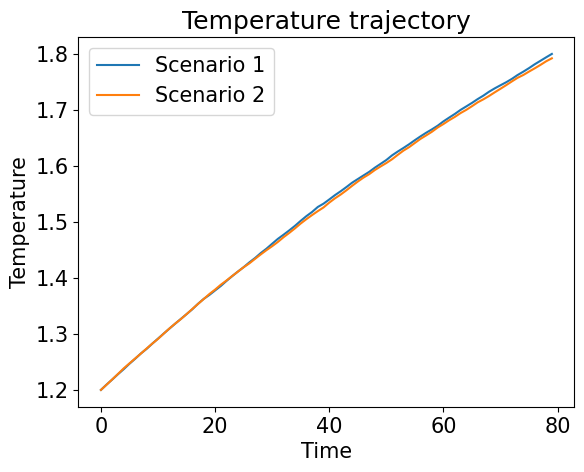

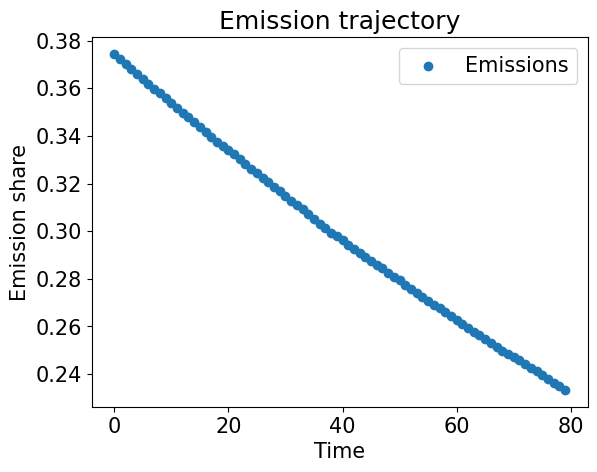

In [19]:
n_periods=80
n_scenarios=2 
X_zero=tf.constant([[S0],[S0]], dtype=tf.float32) #alternative would be np.array
X_sim = sim_periods(X_zero, nn, n_periods)
X_sim = np.reshape(X_sim, (n_scenarios*n_periods, 1)) #unsure if the nn can take in 3D vectors.
E_sim=nn(X_sim)
X_sim = np.reshape(X_sim, (n_periods,n_scenarios, 1))
E_sim = np.reshape(E_sim,(n_periods,n_scenarios, 1))
time=np.arange(n_periods) #or time=np.linspace(0,79,80) but this creates floats rather than integers

plt.title("Temperature trajectory")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.plot(time,X_sim[:,0,:]*zeta, label = "Scenario 1")
plt.plot(time,X_sim[:,1,:]*zeta, label = "Scenario 2")
plt.legend()
plt.show()
plt.close()

plt.title("Emission trajectory")
plt.xlabel("Time")
plt.ylabel("Emission share")
plt.scatter(time, E_sim[:,0,:], label = "Emissions")
plt.legend()
plt.show()
plt.close()